In [13]:
# import geomloss
import numpy as np
import sys
# import torch
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

sys.path.append("..") 

from data import get_database_path, get_h5_files, read_h5_file
from emd import emd_pot, sep_emd
import emd
from visualize import plot_event_cloud, plot_optimal_transport
from utils import load_toml_config

np.random.seed(114514)

In [14]:
import importlib
importlib.reload(emd)
from emd import emd_pot, sep_emd

In [2]:
# SM processes
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])


dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


In [3]:
import torch
import geomloss

a, b = torch.randn((100)), torch.randn((100))
x, y = torch.randn((100, 2)), torch.randn((100, 2))
p = 1
entreg = .1 # entropy regularization factor for Sinkhorn

# 若以欧式距离为metric，则cost function可以直接用geomloss提供的
# Sinkhorn快速解
OTLoss = geomloss.SamplesLoss(
    loss='sinkhorn', p=p,
    # 对于p=1或p=2的情形
    cost=geomloss.utils.distances if p==1 else geomloss.utils.squared_distances,
    blur=0.0001, backend='tensorized')
pW = OTLoss(a, x, b, y)
print(pW.item())

120.81695556640625


In [4]:
def process_events_torch(events):
    pts = events[:, 0]
    coords = events[:, 1:3]
    return torch.as_tensor(pts), torch.as_tensor(coords)

In [5]:
random_index = np.random.randint(len(bkg))
random_source_event = bkg[random_index]
random_target_event = bkg[random_index+1]

source_pts, source_coords = process_events_torch(random_source_event)
target_pts, target_coords = process_events_torch(random_target_event)
geomloss_emd = OTLoss(source_pts, source_coords, target_pts, target_coords)

emd = emd_pot(random_source_event, random_target_event)
print(geomloss_emd.item() - emd)


500.3791369631002


[-6.09776688 -6.09776688]
From: [0. 0.] to [0. 0.] with flow 27.41
From: [0. 0.] to [0. 0.] with flow 6.10
From: [0.47 2.75] to [1.63 1.95] with flow 24.21
From: [0.47 2.75] to [0. 0.] with flow 0.14


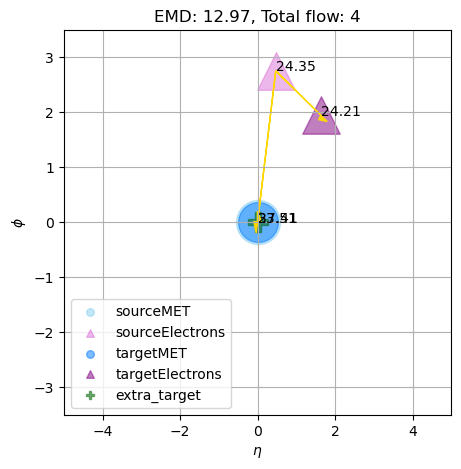

In [6]:
test_target_event = bkg[0]
test_source_event = bkg[1]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True)
print(sep_emd(test_source_event, test_target_event) - emd)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd, verbose=True)

In [15]:
# print(test_source_event)
# print(test_target_event)
print(sep_emd(test_source_event, test_target_event))

12.971146199068858


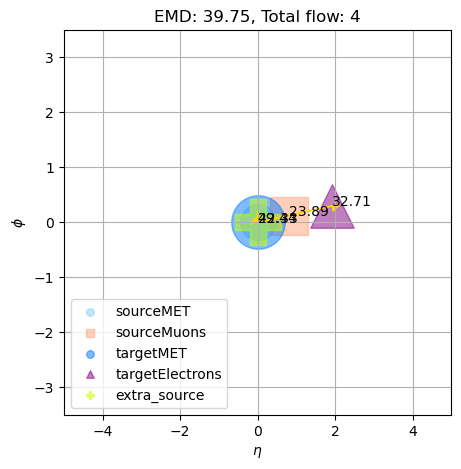

29.491193771362305


In [23]:
test_target_event = bkg[np.random.randint(0, len(bkg))]
test_source_event = bkg[np.random.randint(0, len(bkg))]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd)
print(sep_emd(test_source_event, test_target_event))